In [1]:
from __future__ import division

from microfaune_package.microfaune.detection import RNNDetector
from microfaune_package.microfaune import audio
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import numpy as np
import pdb
import csv
import argparse
from scipy.io import wavfile
import scipy.signal as scipy_signal
import pandas as pd

## Function that attempts to isolate bird calls from clips 

In [2]:
## TODO Modify this function so that a user can play around with different bells and whistles.
def isolate(scores, samples, sample_rate, audio_dir, filename):
    # calculate original duration
    old_duration = len(samples) / sample_rate

    # create entry for audio clip
    entry = {'folder'  : audio_dir,
             'file'    : filename,
             'channel' : 0,
             'duration': old_duration,
             'stamps'  : [],
             'labels'  : []}

    # Variable to modulate when encapsulating this function.
    # treshold is 'thresh_mult' times above median score value
    thresh_mult = 2
    thresh = np.median(scores) * thresh_mult

    
    # how many samples one score represents
    # Scores meaning local scores
    samples_per_score = len(samples) // len(scores)
    
    # isolate samples that produce a score above thresh
    isolated_samples = np.empty(0, dtype=np.int16)
    prev_cap = 0        # sample idx of previously captured
    for i in range(len(scores)):
        # if a score hits or surpasses thresh, capture 1s on both sides of it
        if scores[i] >= thresh:
            # score_pos is the sample index that the score corresponds to
            score_pos = i * samples_per_score
 
            # upper and lower bound of captured call
            # sample rate is # of samples in 1 second: +-1 second
            lo_idx = max(0, score_pos - sample_rate)
            hi_idx = min(len(samples), score_pos + sample_rate)
            lo_time = lo_idx / sample_rate
            hi_time = hi_idx / sample_rate
            
            # calculate start and end stamps
            # create new sample if not overlapping or if first stamp
            if prev_cap < lo_idx or prev_cap == 0:
                new_stamp = [lo_time, hi_time]
                entry['stamps'].append(new_stamp)
                entry['labels'].append(1)
            # extend same stamp if still overlapping
            else:
                entry['stamps'][-1][1] = hi_time

            # mark previously captured to prevent overlap collection
            lo_idx = max(prev_cap, lo_idx)
            prev_cap = hi_idx

            # add to isolated samples
            # sub-clip numpy array
            isolated_samples = np.append(isolated_samples,samples[lo_idx:hi_idx])

    # calculate new duration
    new_duration = len(isolated_samples) / sample_rate
    percent_reduced = 1 - (new_duration / old_duration)
    print('Reduced {} from {:.2f}s to {:.2f}s. {:.2%} reduced.'.format( \
            filename, old_duration, new_duration, percent_reduced))
        
    # write file
    # new_filename = filename[:-4] + "_RED" + filename[-4:]
    # wavfile.write(audio_dir + new_filename, sample_rate, isolated_samples)
    
    return entry

##  Function that creates the CSV of expected bird calls in a clip

In [3]:

def calc_local_scores(bird_dir):
    # TODO optimize detector.predict to not have to take in real file, just numpy arr
    # init detector
    detector = RNNDetector()
    # init labels dict
    annotations = []

    # generate local scores for every bird file in chosen directory
    for audio_file in os.listdir(bird_dir):
        # skip directories
        if os.path.isdir(bird_dir+audio_file): continue
        
        # read file
        raw_sample_rate, raw_samples = wavfile.read(bird_dir + audio_file)
        
        # downsample the sample if > 22.05 kHz
        if raw_sample_rate > 44100:
            rate_ratio = 44100 / raw_sample_rate
            samples = scipy_signal.resample(
                    raw_samples, int(len(raw_samples)*rate_ratio))
            sample_rate = 44100
            # resample produces unreadable float32 array so convert back
            samples = np.asarray(samples, dtype=np.int16)
            
            # add DS to end of downsampled file
            new_filename = audio_file[:-4] + "_DS" + audio_file[-4:]
            audio_file = new_filename
            
            # write downsampled file
            wavfile.write(bird_dir + new_filename, sample_rate, samples)
        else:
            sample_rate = raw_sample_rate
            samples = raw_samples
        
        # convert mono to stereo if needed
        if len(samples.shape) == 2:
            samples = samples.sum(axis=1) / 2

        # detection
        try:
            # for wavs
            if audio_file.lower().endswith('.wav'):
                _, local_score = detector.predict_on_wav(bird_dir + audio_file)
                print("Loaded", audio_file)
            # for mp3s
            elif audio_file.lower().endswith('.mp3'):
                _, local_score = detector.predict(bird_dir + audio_file)
                print("Loaded", audio_file)
            else:
                print("Invalid file extension, skipping", audio_file)
                continue
        except:
            print("Error in file, skipping", audio_file)
            continue
        
        # get duration of clip
        duration = len(samples) / sample_rate
        
        # write local score file in chosen directory
        # not needed for csv output to opensoundscape
        # needed for matplotlib graph of local scores
        with open("./" + audio_file[:-4]+"_LS.txt", "w") as f:
            f.write(str(duration) + "\n")
            f.write(str(len(local_score))+"\n")
            for sc in local_score:
                f.write(str(sc) + '\n')
        
        # isolate bird sounds in the clip by eliminating dead noise
        new_entry = isolate(local_score, samples, sample_rate, bird_dir, audio_file)
        annotations.append(new_entry)

    # generate local scores for every nonbird file in chosen directory
#    for audio_file in os.listdir(nonbird_dir):
        # skip directories
#        if os.path.isdir(nonbird_dir+audio_file): continue
    
        # read file
#        raw_sample_rate, raw_samples = wavfile.read(nonbird_dir + audio_file)
        
        # downsample the sample if > 44.1 kHz
#        if raw_sample_rate > 22050:
#            rate_ratio = 22050 / raw_sample_rate
#            samples = scipy_signal.resample(
#                    raw_samples, int(len(raw_samples)*rate_ratio))
#            sample_rate = 22050
            # resample produces unreadable float32 array so convert back
#            samples = np.asarray(samples, dtype=np.int16)
            
            # add DS to end of downsampled file
#            new_filename = audio_file[:-4] + "_DS" + audio_file[-4:]
#            audio_file = new_filename
            
            # write downsampled file
#            wavfile.write(nonbird_dir + new_filename, sample_rate, samples)
#        else:
#            sample_rate = raw_sample_rate
#            samples = raw_samples
        
        # convert mono to stereo if needed
#        if len(samples.shape) == 2:
#            samples = samples.sum(axis=1) / 2

        # get duration of clip
#        duration = len(samples) / sample_rate

        # create entry for audio clip
#        new_entry = {'folder'  : nonbird_dir,
#                     'file'    : audio_file,
#                     'channel' : 0,
#                     'duration': duration,
#                     'stamps'  : [[0,duration]],
#                     'labels'  : [0]}
#        annotations.append(new_entry)

    # write csv with time stamps and labels
    header = ["FOLDER","IN FILE","CHANNEL","OFFSET","DURATION","MANUAL ID"]
    with open("annotations.csv", "w") as f:
        writer = csv.writer(f)
        # write titles of columns
        writer.writerow(header)
        
        for el in annotations:
            for i in range(len(el['stamps'])):
                clip_duration = el['stamps'][i][1] - el['stamps'][i][0]
                writer.writerow([el['folder'],
                                 el['file'], 
                                 el['channel'],
                                 el['stamps'][i][0], # start time or offset 
                                 clip_duration, # end - start
                                 el['labels'][i]])


In [4]:
# Testing out the two functions above on a test set of some clips
calc_local_scores("/home/jacob/Acoustic-Species-Identification/passive-acoustic-biodiversity/BinaryBirdDet/TEST/")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loaded 20190622_210000_DS.WAV
Reduced 20190622_210000_DS.WAV from 60.00s to 55.34s. 7.76% reduced.
Loaded HowlerMonkey1_DS.WAV
Reduced HowlerMonkey1_DS.WAV from 60.00s to 44.67s. 25.56% reduced.
Loaded 20190622_210000_DS.WAV
Reduced 20190622_210000_DS.WAV from 60.00s to 55.34s. 7.76% reduced.
Loaded 20190624_152000_DS.WAV
Reduced 20190624_152000_DS.WAV from 60.00s to 2.65s. 95.58% reduced.
Loaded 20190623_222000_DS.WAV
Reduced 20190623_222000_DS.WAV from 60.00s to 13.33s. 77.78% reduced.
Loaded BlackFacedAntbird1.wav
Reduced BlackFacedAntbird1.wav from 31.22s

## Function that uses the local scores and compares to the spectrogram

In [5]:
def local_line_graph(local_scores, clip_name, scores_dir):
    # load signal to get spectrogram
    #home = str(Path.home())
    #wav_path = os.path.join(
    #        home, "../../media/e4e/New Volume/AudiomothData/AM15_16_Birds/")
    # remove file extension and _LS label from end of file
#    wav_name = wav_path + clip_name[:-7] + ".WAV"
    # load file
    sample_rate, samples = wavfile.read(clip_name)

    # calculate time stamps - x axis
    # takes first two lines
    duration = local_scores.pop(0)
    num_scores = local_scores.pop(0)

    step = duration / num_scores
    time_stamps = np.arange(0, duration, step)

    if len(time_stamps) > len(local_scores):
        time_stamps = time_stamps[:-1]

    # general graph features
    fig, axs = plt.subplots(2)
    fig.set_figwidth(22)
    fig.set_figheight(10)
    fig.suptitle("Spectrogram and Local Scores for "+clip_name)
    # score line plot - top plot
    axs[0].plot(time_stamps, local_scores)
    axs[0].set_xlim(0,duration)
    axs[0].set_ylim(0,1)
    axs[0].grid(which='major', linestyle='-')
    # spectrogram - bottom plot
    # TODO Use axvspan to highlight the human labeled regions and microfaune annotated regions
    # Will require the input of a pandas dataframe
    Pxx, freqs, bins, im = axs[1].specgram(samples, Fs=sample_rate,
            NFFT=4096, noverlap=2048,
            window=np.hanning(4096), cmap="ocean")
    axs[1].set_xlim(0,duration)
    axs[1].set_ylim(0,22050)
    axs[1].grid(which='major', linestyle='-')

    # save graph
#    plt.savefig("test.png")


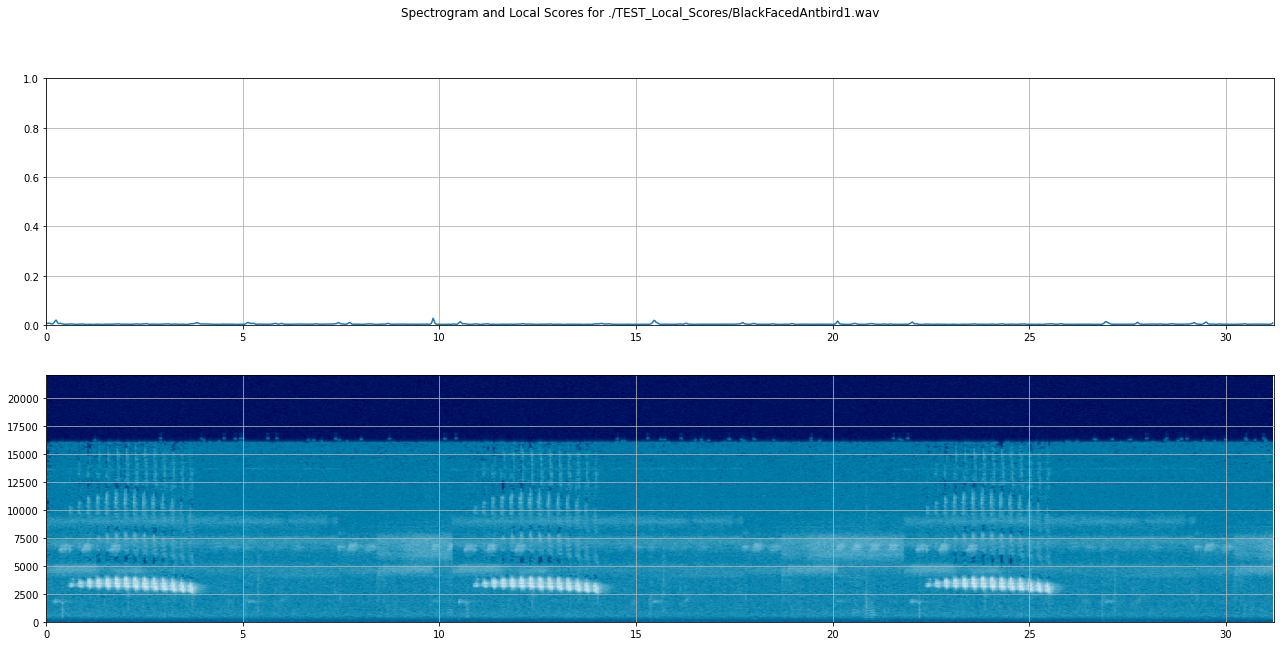

In [6]:
# Quick Test on a xeno-canto clip
local_scores = []
with open("./TEST_Local_Scores/BlackFacedAntbird1_LS.txt","r") as f:
    for line in f:
        local_scores.append(float(line.strip()))
local_line_graph(local_scores, "./TEST_Local_Scores/BlackFacedAntbird1.wav", "./TEST_Local_Scores/")

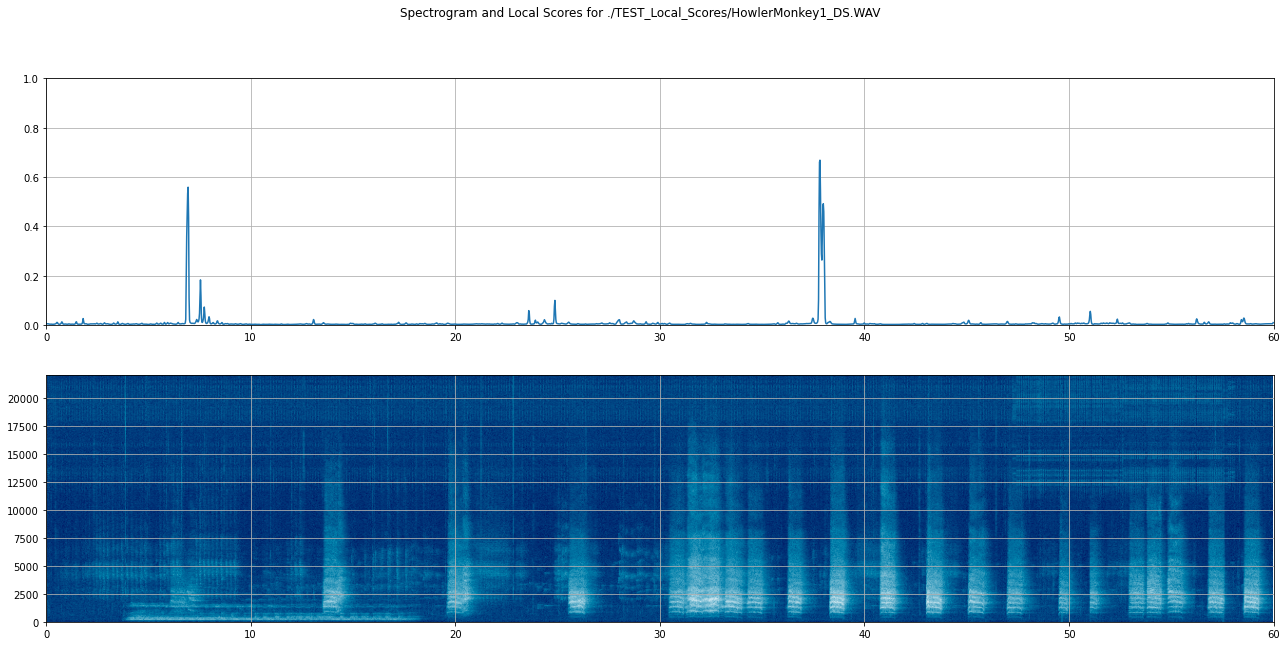

In [7]:
# Quick Test on an Audiomoth File
local_scores_AM = []
with open("./TEST_Local_Scores/HowlerMonkey1_DS_LS.txt","r") as f:
    for line in f:
        local_scores_AM.append(float(line.strip()))
local_line_graph(local_scores_AM, "./TEST_Local_Scores/HowlerMonkey1_DS.WAV", "./TEST_Local_Scores/")

## Testing out highlighting regions on a spectrogram

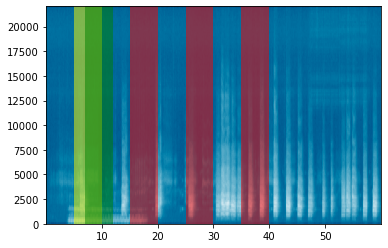

In [8]:
file_path = "./TEST_Local_Scores/HowlerMonkey1_DS.WAV"
SAMPLE_RATE, SIGNAL = wavfile.read(file_path)
plt.specgram(SIGNAL,Fs=SAMPLE_RATE,cmap="ocean");
plt.axvspan(xmin=5,xmax=10,facecolor='yellow',alpha=0.5)
minval = 15
maxval = 20
for ndx in range(3):
    plt.axvspan(xmin=minval,xmax=maxval,facecolor='red',alpha=0.5)
    minval += 10
    maxval += 10
plt.axvspan(xmin=7,xmax=12,facecolor="green",alpha=0.5)

## Highlighting based on the automated csv labels

HowlerMonkey1_DS.WAV


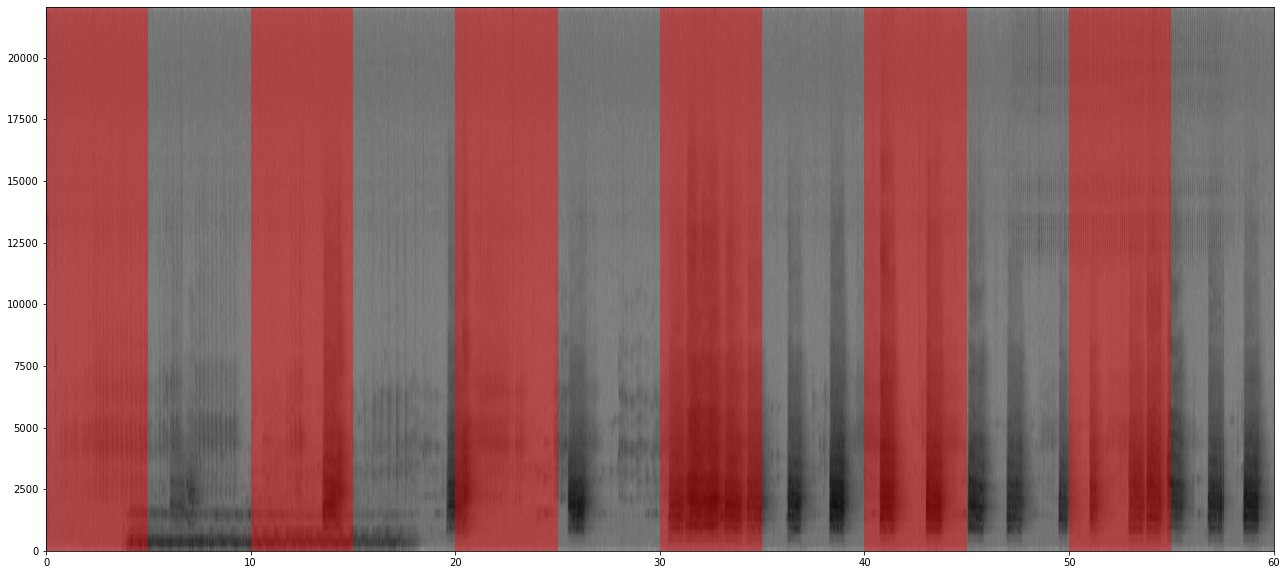

In [9]:
# Taking in the automated microfaune labels
test_automated_labels = pd.read_csv("annotations.csv");
fake_human_labels = pd.read_csv("test_ground_truth.csv");
# Reducing it down to just the clip that we want.
file_name = file_path.split("/")
file_name = file_name[-1]
print(file_name)
specific_clip_dataframe_bot = test_automated_labels[test_automated_labels['IN FILE'].str.contains(file_name)]
specific_clip_dataframe_human = fake_human_labels[fake_human_labels['IN FILE'].str.contains(file_name)]
#print(specific_clip_dataframe)
# Creating a new spectrogram
plt.figure(figsize=(22,10))
plt.specgram(SIGNAL,Fs = SAMPLE_RATE, cmap="Greys")
# Looping through each row in the reduced dataframe
#for row in specific_clip_dataframe_bot.index:
#    minval = specific_clip_dataframe_bot["OFFSET"][row]
#    maxval = specific_clip_dataframe_bot["OFFSET"][row] + specific_clip_dataframe_bot["DURATION"][row]
#    plt.axvspan(xmin=minval,xmax=maxval,facecolor="yellow",alpha=0.4)
for row in specific_clip_dataframe_human.index:
    minval = specific_clip_dataframe_human["OFFSET"][row]
    maxval = specific_clip_dataframe_human["OFFSET"][row] + specific_clip_dataframe_human["DURATION"][row]
    plt.axvspan(xmin=minval,xmax=maxval,facecolor="red",alpha=0.4)
plt.xlim(0,60);
plt.savefig("Annotations_Highlights.png")

Bird Label Overlap Percentage: 0.618


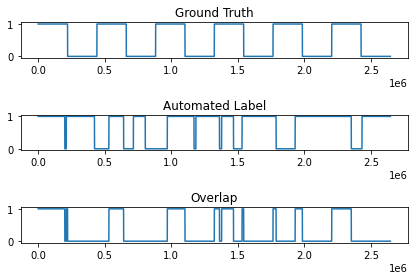

In [13]:
## Create a function to compare the annotations of microfaune to human labels overlap/ground_truth

# Initializing some numpy arrays
human_arr = np.zeros(SIGNAL.shape)
bot_arr = np.zeros(SIGNAL.shape)

# 
for row in specific_clip_dataframe_bot.index:
    minval = int(round(specific_clip_dataframe_bot["OFFSET"][row]*SAMPLE_RATE,0))
    maxval = int(round((specific_clip_dataframe_bot["OFFSET"][row] + specific_clip_dataframe_bot["DURATION"][row]) *SAMPLE_RATE,0))
    bot_arr[minval:maxval] = 1
for row in specific_clip_dataframe_human.index:
    minval = int(round(specific_clip_dataframe_human["OFFSET"][row]*SAMPLE_RATE,0))
    maxval = int(round((specific_clip_dataframe_human["OFFSET"][row] + specific_clip_dataframe_human["DURATION"][row])*SAMPLE_RATE,0))
    human_arr[minval:maxval] = 1
plt.subplot(3,1,1)
plt.plot(human_arr)
plt.title("Ground Truth")
plt.subplot(3,1,2)
plt.plot(bot_arr)
plt.title("Automated Label")
# Finding where there exists overlap between the human label and automated bird labels.
bird_label_overlap = human_arr*bot_arr
plt.subplot(3,1,3)
plt.plot(bird_label_overlap)
plt.title("Overlap")
plt.tight_layout()


# Comparing the overlap of bird labels to ground truth.
overlap_bird = len(np.where(bird_label_overlap==1)[0])
#print(overlap_bird)
human_label_size = len(np.where(human_arr==1)[0])
#print(human_label_size)
print("Bird Label Overlap Percentage: " + str(round(overlap_bird/human_label_size,4)))

## Compare where the arrays are 1 and 0 independently.
#overlap_size = np.where(human_arr==bot_arr)
#overlap_size = len(overlap_size[0])
#print(overlap_size)
#human_label_size = np.where(human_arr==1)
#human_label_size = len(human_label_size[0])
#print(human_label_size)
#print("Overlap percentage: " + str(round(overlap_size/human_label_size,4)))

In [17]:
# Quick test to compare predict_on_wav and predict in microfaune

model = RNNDetector()
global1,local1 = model.predict_on_wav("./TEST/BlackFacedAntbird1.wav")
print(global1)

# This will allow us to downsample the numpy array itself without having to write out a new wav file.
test_fs,test_signal = audio.load_wav("./TEST/BlackFacedAntbird1.wav")
features = model.compute_features([test_signal])
global2,local2 = model.predict(features)
print(local2[0])
print(global2[0])

[0.02843055]
[0.01014441 0.00748736 0.00769642 ... 0.00479946 0.00620949 0.00922226]
[0.02843055]


## Reworking calc_local_scores function 

In [43]:
## Making sure that it doesn't rewrite the wav files anymore, instead just makes predictions on numpy arrays.
def calc_local_scores_reworked(bird_dir):
    # init detector
    # TODO Make it so that we can modify which weights are being used.
    detector = RNNDetector()
    # init labels dict
    annotations = []

    # generate local scores for every bird file in chosen directory
    for audio_file in os.listdir(bird_dir):
        # skip directories
        if os.path.isdir(bird_dir+audio_file): continue
        
        # read file
        SAMPLE_RATE, SIGNAL = audio.load_wav(bird_dir + audio_file)
        
        # downsample the audio if the sample rate > 44.1 kHz
        # Force everything into the human hearing range.
        if SAMPLE_RATE > 44100:
            rate_ratio = 44100 / SAMPLE_RATE
            SIGNAL = scipy_signal.resample(
                    SIGNAL, int(len(SIGNAL)*rate_ratio))
            SAMPLE_RATE = 44100
            # resample produces unreadable float32 array so convert back
            #SIGNAL = np.asarray(SIGNAL, dtype=np.int16)
            
        #print(SIGNAL.shape)
        # convert stereo to mono if needed
        # Might want to compare to just taking the first set of data.
        if len(SIGNAL.shape) == 2:
            SIGNAL = SIGNAL.sum(axis=1) / 2

        # detection
        try:
            microfaune_features = detector.compute_features([SIGNAL])
            global_score,local_scores = detector.predict(microfaune_features)
        except:
            print("Error in detection, skipping", audio_file)
            continue
        
        # get duration of clip
        duration = len(SIGNAL) / SAMPLE_RATE
        
        # write local score file in chosen directory
        # not needed for csv output to opensoundscape
        # needed for matplotlib graph of local scores
        with open("./" + audio_file[:-4]+"_LS.txt", "w") as f:
            f.write(str(duration) + "\n")
            f.write(str(len(local_scores[0]))+"\n")
            for sc in local_scores[0]:
                f.write(str(sc) + '\n')
        
        # isolate bird sounds in the clip by eliminating dead noise
        new_entry = isolate(local_scores[0], SIGNAL, SAMPLE_RATE, bird_dir, audio_file)
        annotations.append(new_entry)


    # write csv with time stamps and labels
    header = ["FOLDER","IN FILE","CHANNEL","OFFSET","DURATION","MANUAL ID"]
    with open("annotations_numpy_version.csv", "w") as f:
        writer = csv.writer(f)
        # write titles of columns
        writer.writerow(header)
        
        for el in annotations:
            for i in range(len(el['stamps'])):
                clip_duration = el['stamps'][i][1] - el['stamps'][i][0]
                writer.writerow([el['folder'],
                                 el['file'], 
                                 el['channel'],
                                 el['stamps'][i][0], # start time or offset 
                                 clip_duration, # end - start
                                 el['labels'][i]])


In [44]:
# Testing out the modified calc_local_scores
calc_local_scores_reworked("/home/jacob/Acoustic-Species-Identification/passive-acoustic-biodiversity/BinaryBirdDet/TEST/")
# Works for now, will want to rewrite where it returns a pandas dataframe instead of just writing out a csv file.

Reduced 20190622_210000.WAV from 60.00s to 55.34s. 7.76% reduced.
Reduced BlackFacedAntbird1.wav from 31.22s to 23.11s. 25.97% reduced.
Reduced 20190624_152000.WAV from 60.00s to 2.65s. 95.58% reduced.
Reduced ScreamingPiha2.wav from 33.93s to 28.49s. 16.04% reduced.
Reduced HowlerMonkey1.WAV from 60.00s to 44.67s. 25.56% reduced.
Reduced 20190623_222000.WAV from 60.00s to 13.33s. 77.78% reduced.


In [50]:
# Reworking Gabriel's Isolation Script so that it returns a Pandas dataframe
# Ultimate Goal is to make it so that none of the scripts are automatically writing files.

def isolate_reworked(scores, samples, sample_rate, audio_dir, filename):
    # calculate original duration
    old_duration = len(samples) / sample_rate

    # create entry for audio clip
    entry = {'folder'  : audio_dir,
             'file'    : filename,
             'channel' : 0,
             'duration': old_duration,
             'stamps'  : [],
             'labels'  : []}

    # Variable to modulate when encapsulating this function.
    # treshold is 'thresh_mult' times above median score value
    thresh_mult = 2
    thresh = np.median(scores) * thresh_mult

    
    # how many samples one score represents
    # Scores meaning local scores
    samples_per_score = len(samples) // len(scores)
    
    # isolate samples that produce a score above thresh
    isolated_samples = np.empty(0, dtype=np.int16)
    prev_cap = 0        # sample idx of previously captured
    for i in range(len(scores)):
        # if a score hits or surpasses thresh, capture 1s on both sides of it
        if scores[i] >= thresh:
            # score_pos is the sample index that the score corresponds to
            score_pos = i * samples_per_score
 
            # upper and lower bound of captured call
            # sample rate is # of samples in 1 second: +-1 second
            lo_idx = max(0, score_pos - sample_rate)
            hi_idx = min(len(samples), score_pos + sample_rate)
            lo_time = lo_idx / sample_rate
            hi_time = hi_idx / sample_rate
            
            # calculate start and end stamps
            # create new sample if not overlapping or if first stamp
            if prev_cap < lo_idx or prev_cap == 0:
                new_stamp = [lo_time, hi_time]
                entry['stamps'].append(new_stamp)
                entry['labels'].append(1)
            # extend same stamp if still overlapping
            else:
                entry['stamps'][-1][1] = hi_time

            # mark previously captured to prevent overlap collection
            lo_idx = max(prev_cap, lo_idx)
            prev_cap = hi_idx

            # add to isolated samples
            # sub-clip numpy array
            isolated_samples = np.append(isolated_samples,samples[lo_idx:hi_idx])

    # calculate new duration
    #new_duration = len(isolated_samples) / sample_rate
    #percent_reduced = 1 - (new_duration / old_duration)
    #print('Reduced {} from {:.2f}s to {:.2f}s. {:.2%} reduced.'.format( \
    #        filename, old_duration, new_duration, percent_reduced))
        
    # write file
    # new_filename = filename[:-4] + "_RED" + filename[-4:]
    # wavfile.write(audio_dir + new_filename, sample_rate, isolated_samples)
    entry = pd.DataFrame.from_dict(entry)
    return entry

In [64]:
# Testing out the new version of isolate
test = isolate_reworked(local2[0],test_signal,test_fs,"test_dir","test?")
print(test)

     folder   file  channel   duration  \
0  test_dir  test?        0  31.216327   
1  test_dir  test?        0  31.216327   
2  test_dir  test?        0  31.216327   
3  test_dir  test?        0  31.216327   
4  test_dir  test?        0  31.216327   
5  test_dir  test?        0  31.216327   
6  test_dir  test?        0  31.216327   
7  test_dir  test?        0  31.216327   

                                     stamps  labels  
0                 [0.0, 1.2783673469387755]       1  
1   [2.8043537414965987, 6.172993197278911]       1  
2      [6.42312925170068, 8.72469387755102]       1  
3   [8.812448979591837, 11.554761904761905]       1  
4    [14.402993197278912, 16.5421768707483]       1  
5   [16.69952380952381, 18.722721088435375]       1  
6  [19.088843537414967, 23.037414965986393]       1  
7  [25.908843537414967, 31.216326530612246]       1  


In [61]:
## Making sure that it doesn't rewrite the wav files anymore, instead just makes predictions on numpy arrays.
def calc_local_scores_pandas(bird_dir):
    # init detector
    # TODO Make it so that we can modify which weights are being used.
    detector = RNNDetector()
    
    # init labels dict
    annotations = {}

    # generate local scores for every bird file in chosen directory
    for audio_file in os.listdir(bird_dir):
        # skip directories
        if os.path.isdir(bird_dir+audio_file): continue
        
        # read file
        SAMPLE_RATE, SIGNAL = audio.load_wav(bird_dir + audio_file)
        
        # downsample the audio if the sample rate > 44.1 kHz
        # Force everything into the human hearing range.
        if SAMPLE_RATE > 44100:
            rate_ratio = 44100 / SAMPLE_RATE
            SIGNAL = scipy_signal.resample(
                    SIGNAL, int(len(SIGNAL)*rate_ratio))
            SAMPLE_RATE = 44100
            # resample produces unreadable float32 array so convert back
            #SIGNAL = np.asarray(SIGNAL, dtype=np.int16)
            
        #print(SIGNAL.shape)
        # convert stereo to mono if needed
        # Might want to compare to just taking the first set of data.
        if len(SIGNAL.shape) == 2:
            SIGNAL = SIGNAL.sum(axis=1) / 2

        # detection
        try:
            microfaune_features = detector.compute_features([SIGNAL])
            global_score,local_scores = detector.predict(microfaune_features)
        except:
            print("Error in detection, skipping", audio_file)
            continue
        
        # get duration of clip
        duration = len(SIGNAL) / SAMPLE_RATE
        
        # isolate bird sounds in the clip by eliminating dead noise
        new_entry = isolate(local_scores[0], SIGNAL, SAMPLE_RATE, bird_dir, audio_file)
        annotations.update(new_entry)
    # This doesn't work for now, will have rework gabriel's conversion to csv to instead
    # convert into a pandas dataframe.
    return pd.DataFrame.from_dict(annotations)


    # write csv with time stamps and labels
    #header = ["FOLDER","IN FILE","CHANNEL","OFFSET","DURATION","MANUAL ID"]
    #with open("annotations_numpy_version.csv", "w") as f:
    #    writer = csv.writer(f)
        # write titles of columns
   #     writer.writerow(header)
   #     
   #     for el in annotations:
   #         for i in range(len(el['stamps'])):
   #             clip_duration = el['stamps'][i][1] - el['stamps'][i][0]
   #             writer.writerow([el['folder'],
   #                              el['file'], 
   #                              el['channel'],
   #                              el['stamps'][i][0], # start time or offset 
   #                              clip_duration, # end - start
   #                              el['labels'][i]])


In [62]:
# Testing out the modified calc_local_scores
test_df = calc_local_scores_pandas("/home/jacob/Acoustic-Species-Identification/passive-acoustic-biodiversity/BinaryBirdDet/TEST/")
# Works for now, will want to rewrite where it returns a pandas dataframe instead of just writing out a csv file.
print(test_df)

Reduced 20190622_210000.WAV from 60.00s to 55.34s. 7.76% reduced.
Reduced BlackFacedAntbird1.wav from 31.22s to 23.11s. 25.97% reduced.
Reduced 20190624_152000.WAV from 60.00s to 2.65s. 95.58% reduced.
Reduced ScreamingPiha2.wav from 33.93s to 28.49s. 16.04% reduced.
Reduced HowlerMonkey1.WAV from 60.00s to 44.67s. 25.56% reduced.
Reduced 20190623_222000.WAV from 60.00s to 13.33s. 77.78% reduced.
                                              folder                 file  \
0  /home/jacob/Acoustic-Species-Identification/pa...  20190623_222000.WAV   
1  /home/jacob/Acoustic-Species-Identification/pa...  20190623_222000.WAV   
2  /home/jacob/Acoustic-Species-Identification/pa...  20190623_222000.WAV   

   channel  duration                                    stamps  labels  
0        0      60.0  [18.276938775510203, 26.748979591836736]       1  
1        0      60.0   [54.07034013605442, 56.093537414965986]       1  
2        0      60.0    [56.94680272108844, 59.78190476190476]       1  

In [63]:
test_df.to_csv("new_pandas_csv2.csv",index=False)